# Risk-Averse RL in a Driving Game

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import gym
import time
import DrivingSim, DrivingLab
import Agents
import utils

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)
torch.set_printoptions(linewidth=150)

In [2]:
# Whether to load existing results or train new agents
LOAD_ONLY = True

## The Driving benchmark

A sample episode of a random agent:

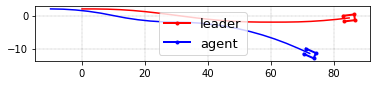

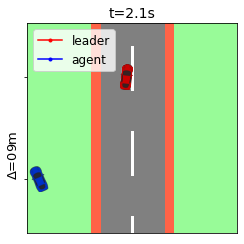

In [3]:
# Make sure the environment is registered
if 'DrivingSim-v0' in gym.envs.registry.env_specs:
    del gym.envs.registry.env_specs['DrivingSim-v0']
gym.envs.registration.register(id='DrivingSim-v0', entry_point='DrivingSim:DrivingSim')

# Run a sample episode with random actions
env = gym.make('DrivingSim-v0')
env.reset()
done = False
while not done:
    obs, r, done, info = env.step(env.action_space.sample())
env.show_trajectory()
env.show_frame()
plt.tight_layout()

env.close()

## CE for risk-averse RL-based driver

In [4]:
%%time

title = 'DrivingGameFinal'

# Define agents (note that the training hyperparams are also defined here through the dict train_hparams)
agents = dict(
    PG = (Agents.FC, dict(train_hparams=dict())),
    GCVaR = (Agents.FC, dict(train_hparams=dict(cvar=0.01))),
    CeSoR = (Agents.FC, dict(train_hparams=dict(cvar=0.01, ce_update_freq=1, soft_cvar=0.8))),
);

# Run experiment
E = DrivingLab.Experiment(agents, train_episodes=200000, title=title)
if LOAD_ONLY:
    E.load_results(agents=True, optimizers=True, CEs=True)
else:
    E.train()
    E.test()
    E.save_results()

E.dd

Wall time: 41.9 s


,agent,group,episode,ag_updates,ag_hash,ag_temperature,p_0,p_acc,p_dec,p_hard,...,th0,brakes,oil,L,log_prob,ret_loss,score,opt_selected,ce_selected,weight
0,PG,train,0,0,0x511685e646003194,1,0.35,0.3,0.248,0.002,...,0.000000,0.0,0.0,6,-5.885499,-3450.978027,-1180.123319,1.0,NaN,NaN
1,PG,train,1,0,0x511685e646003194,1,0.35,0.3,0.248,0.002,...,0.000000,0.0,0.0,6,-9.936512,-2889.093994,-882.457156,1.0,NaN,NaN
2,PG,train,2,0,0x511685e646003194,1,0.35,0.3,0.248,0.002,...,0.000000,0.0,0.0,6,-8.374866,-2895.269775,-859.550186,1.0,NaN,NaN
3,PG,train,3,0,0x511685e646003194,1,0.35,0.3,0.248,0.002,...,0.216313,0.0,0.0,6,-17.502853,-1037.686035,-631.024308,1.0,NaN,NaN
4,PG,train,4,0,0x511685e646003194,1,0.35,0.3,0.248,0.002,...,-0.209034,0.0,0.0,6,-4.809750,-3136.851807,-1085.126747,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603595,CeSoR,test,1195,500,-0x273417396d05d60c,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-4.647061,-18.979528,-268.090431,NaN,NaN,NaN
603596,CeSoR,test,1196,500,-0x273417396d05d60c,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-13.436738,-58.305702,-341.623854,NaN,NaN,NaN
603597,CeSoR,test,1197,500,-0x273417396d05d60c,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-5.952942,-26.946156,-286.121575,NaN,NaN,NaN
603598,CeSoR,test,1198,500,-0x273417396d05d60c,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-5.752578,-41.937462,-520.835748,NaN,NaN,NaN


### Experiment analysis

PG (420/500):	mean=-260.2	CVaR05=-488.9	CVaR01=-753.9
GCVaR (490/500):	mean=-563.9	CVaR05=-713.9	CVaR01=-774.4
CeSoR (370/500):	mean=-311.9	CVaR05=-478.9	CVaR01=-540.6
Wall time: 1min 7s


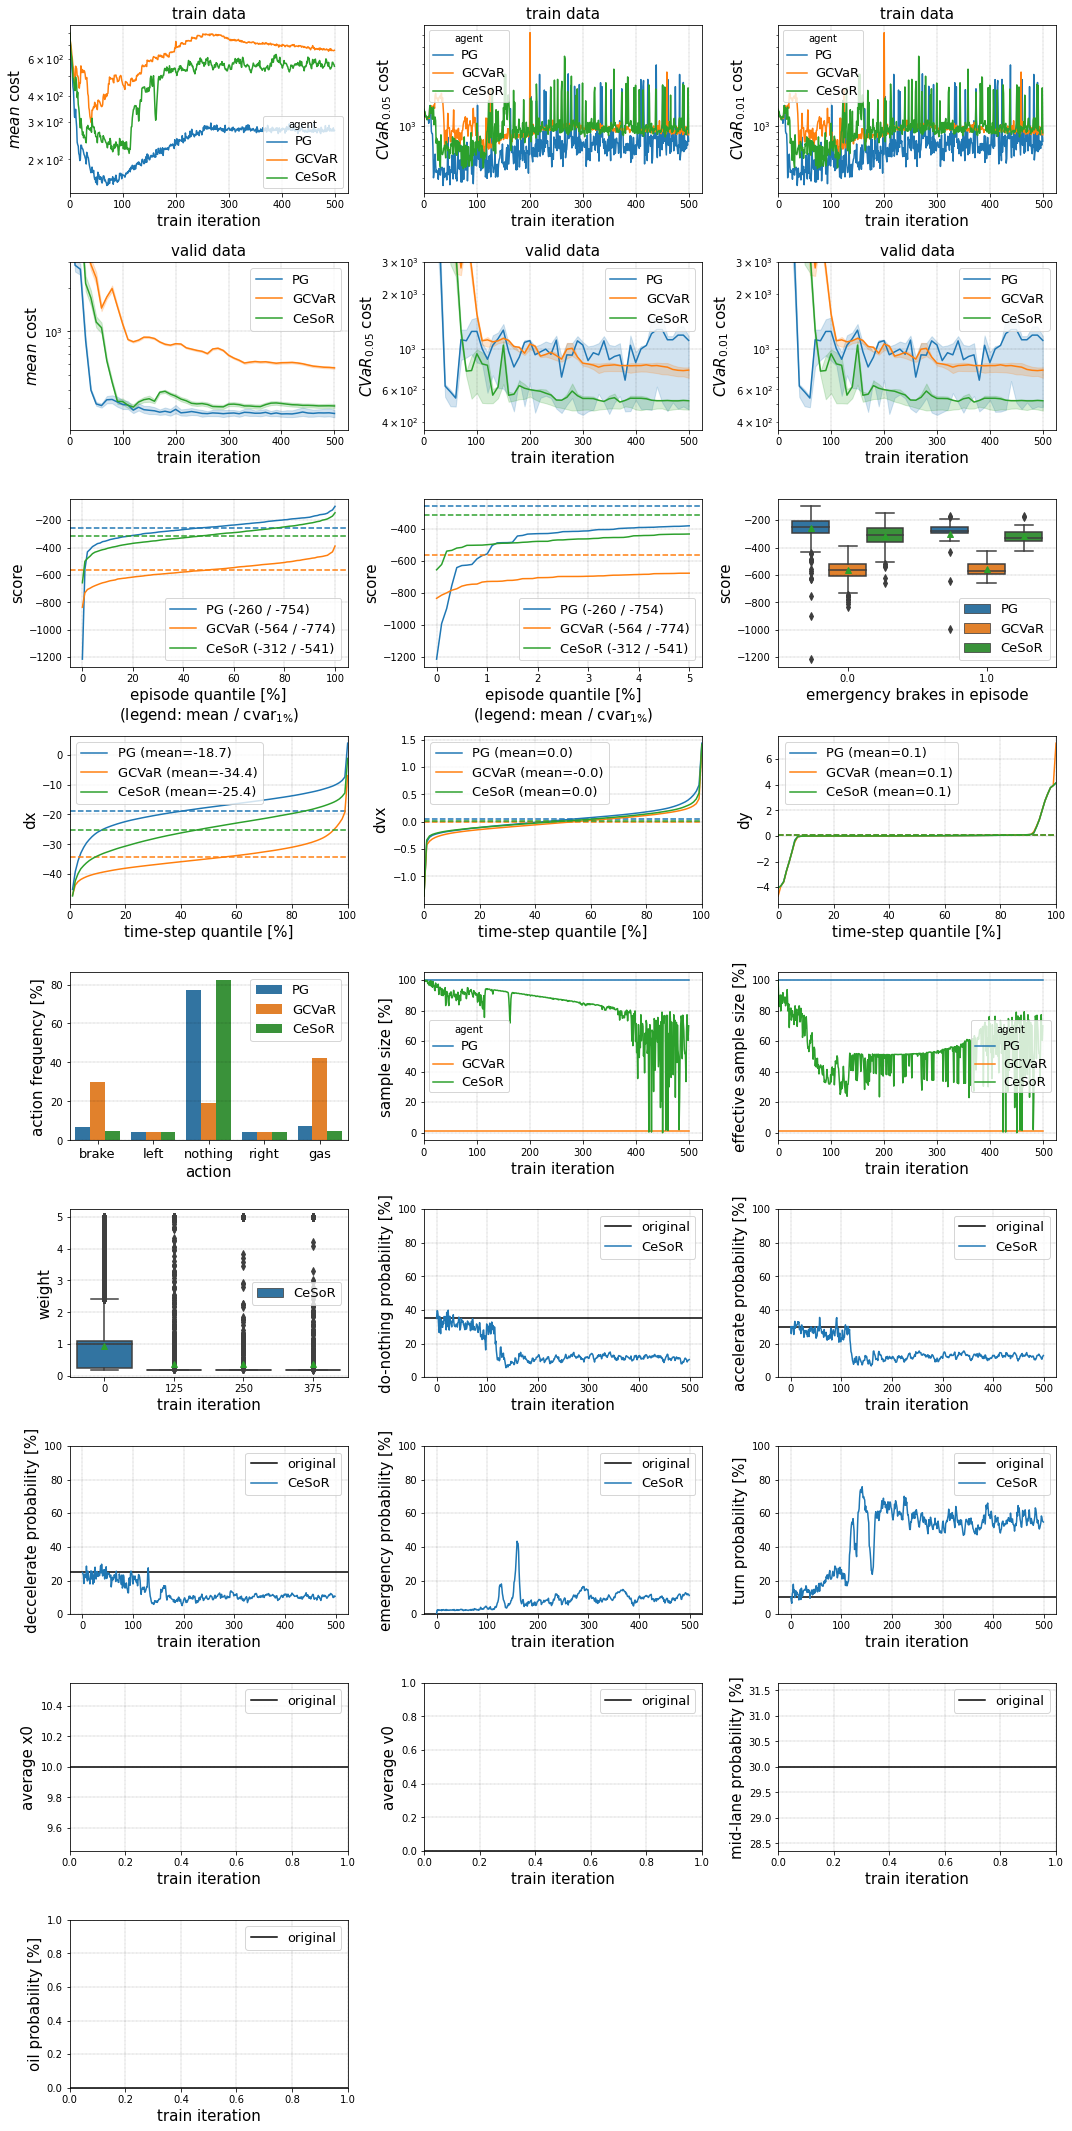

In [5]:
%%time
axs = E.analyze()
axs[3].legend(fontsize=13, loc='upper right')
axs[4].legend(fontsize=13, loc='upper right')
axs[5].legend(fontsize=13, loc='upper right')
plt.savefig(f'outputs/{title}_summary.png', bbox_inches='tight');

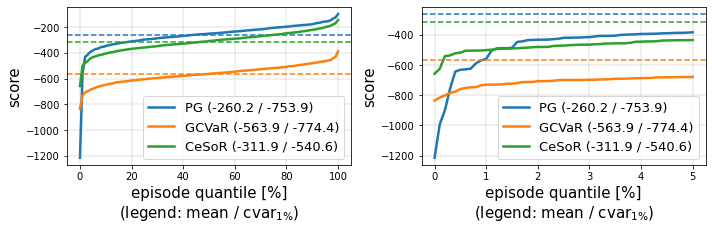

In [6]:
test_df = E.dd[E.dd.group=='test']
axs = utils.Axes(2, 2, (5,3.3), fontsize=15)
a = 0

n_iters = E.n_train // E.optim_freq
cvar = lambda x, alpha: np.mean(np.sort(x)[:int(np.ceil(alpha*len(x)))])
for Q in (100, 5):
    for agent in E.agents_names:
        scores = test_df.score[test_df.agent==agent].values
        utils.plot_quantiles(
            scores, q=np.linspace(0,Q,101)/100, ax=axs[a], linewidth=2.5, showmeans=True,
            label=f'{agent} ({np.mean(scores):.1f} / {cvar(scores, 0.01):.1f})')
    # axs[a].set_ylim((-250,None))
    axs.labs(a, 'episode quantile [%]\n(legend: mean / cvar$_{1\%}$)', 'score')
    axs[a].legend(fontsize=13)
    a += 1
plt.tight_layout()
plt.savefig(f'outputs/{title}_test.png', bbox_inches='tight');

CE distribution over training:

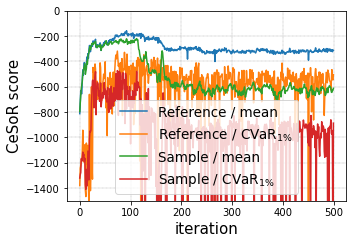

In [7]:
ax = E.CEs['CeSoR'].show_sampled_scores(None, 'CeSoR score')
ax.set_ylim((-1500,0))
ax.legend(loc='lower center', fontsize=13.5)
plt.savefig(f'outputs/{title}_CE.png', bbox_inches='tight');

A sample of test episodes:

Wall time: 16.6 s


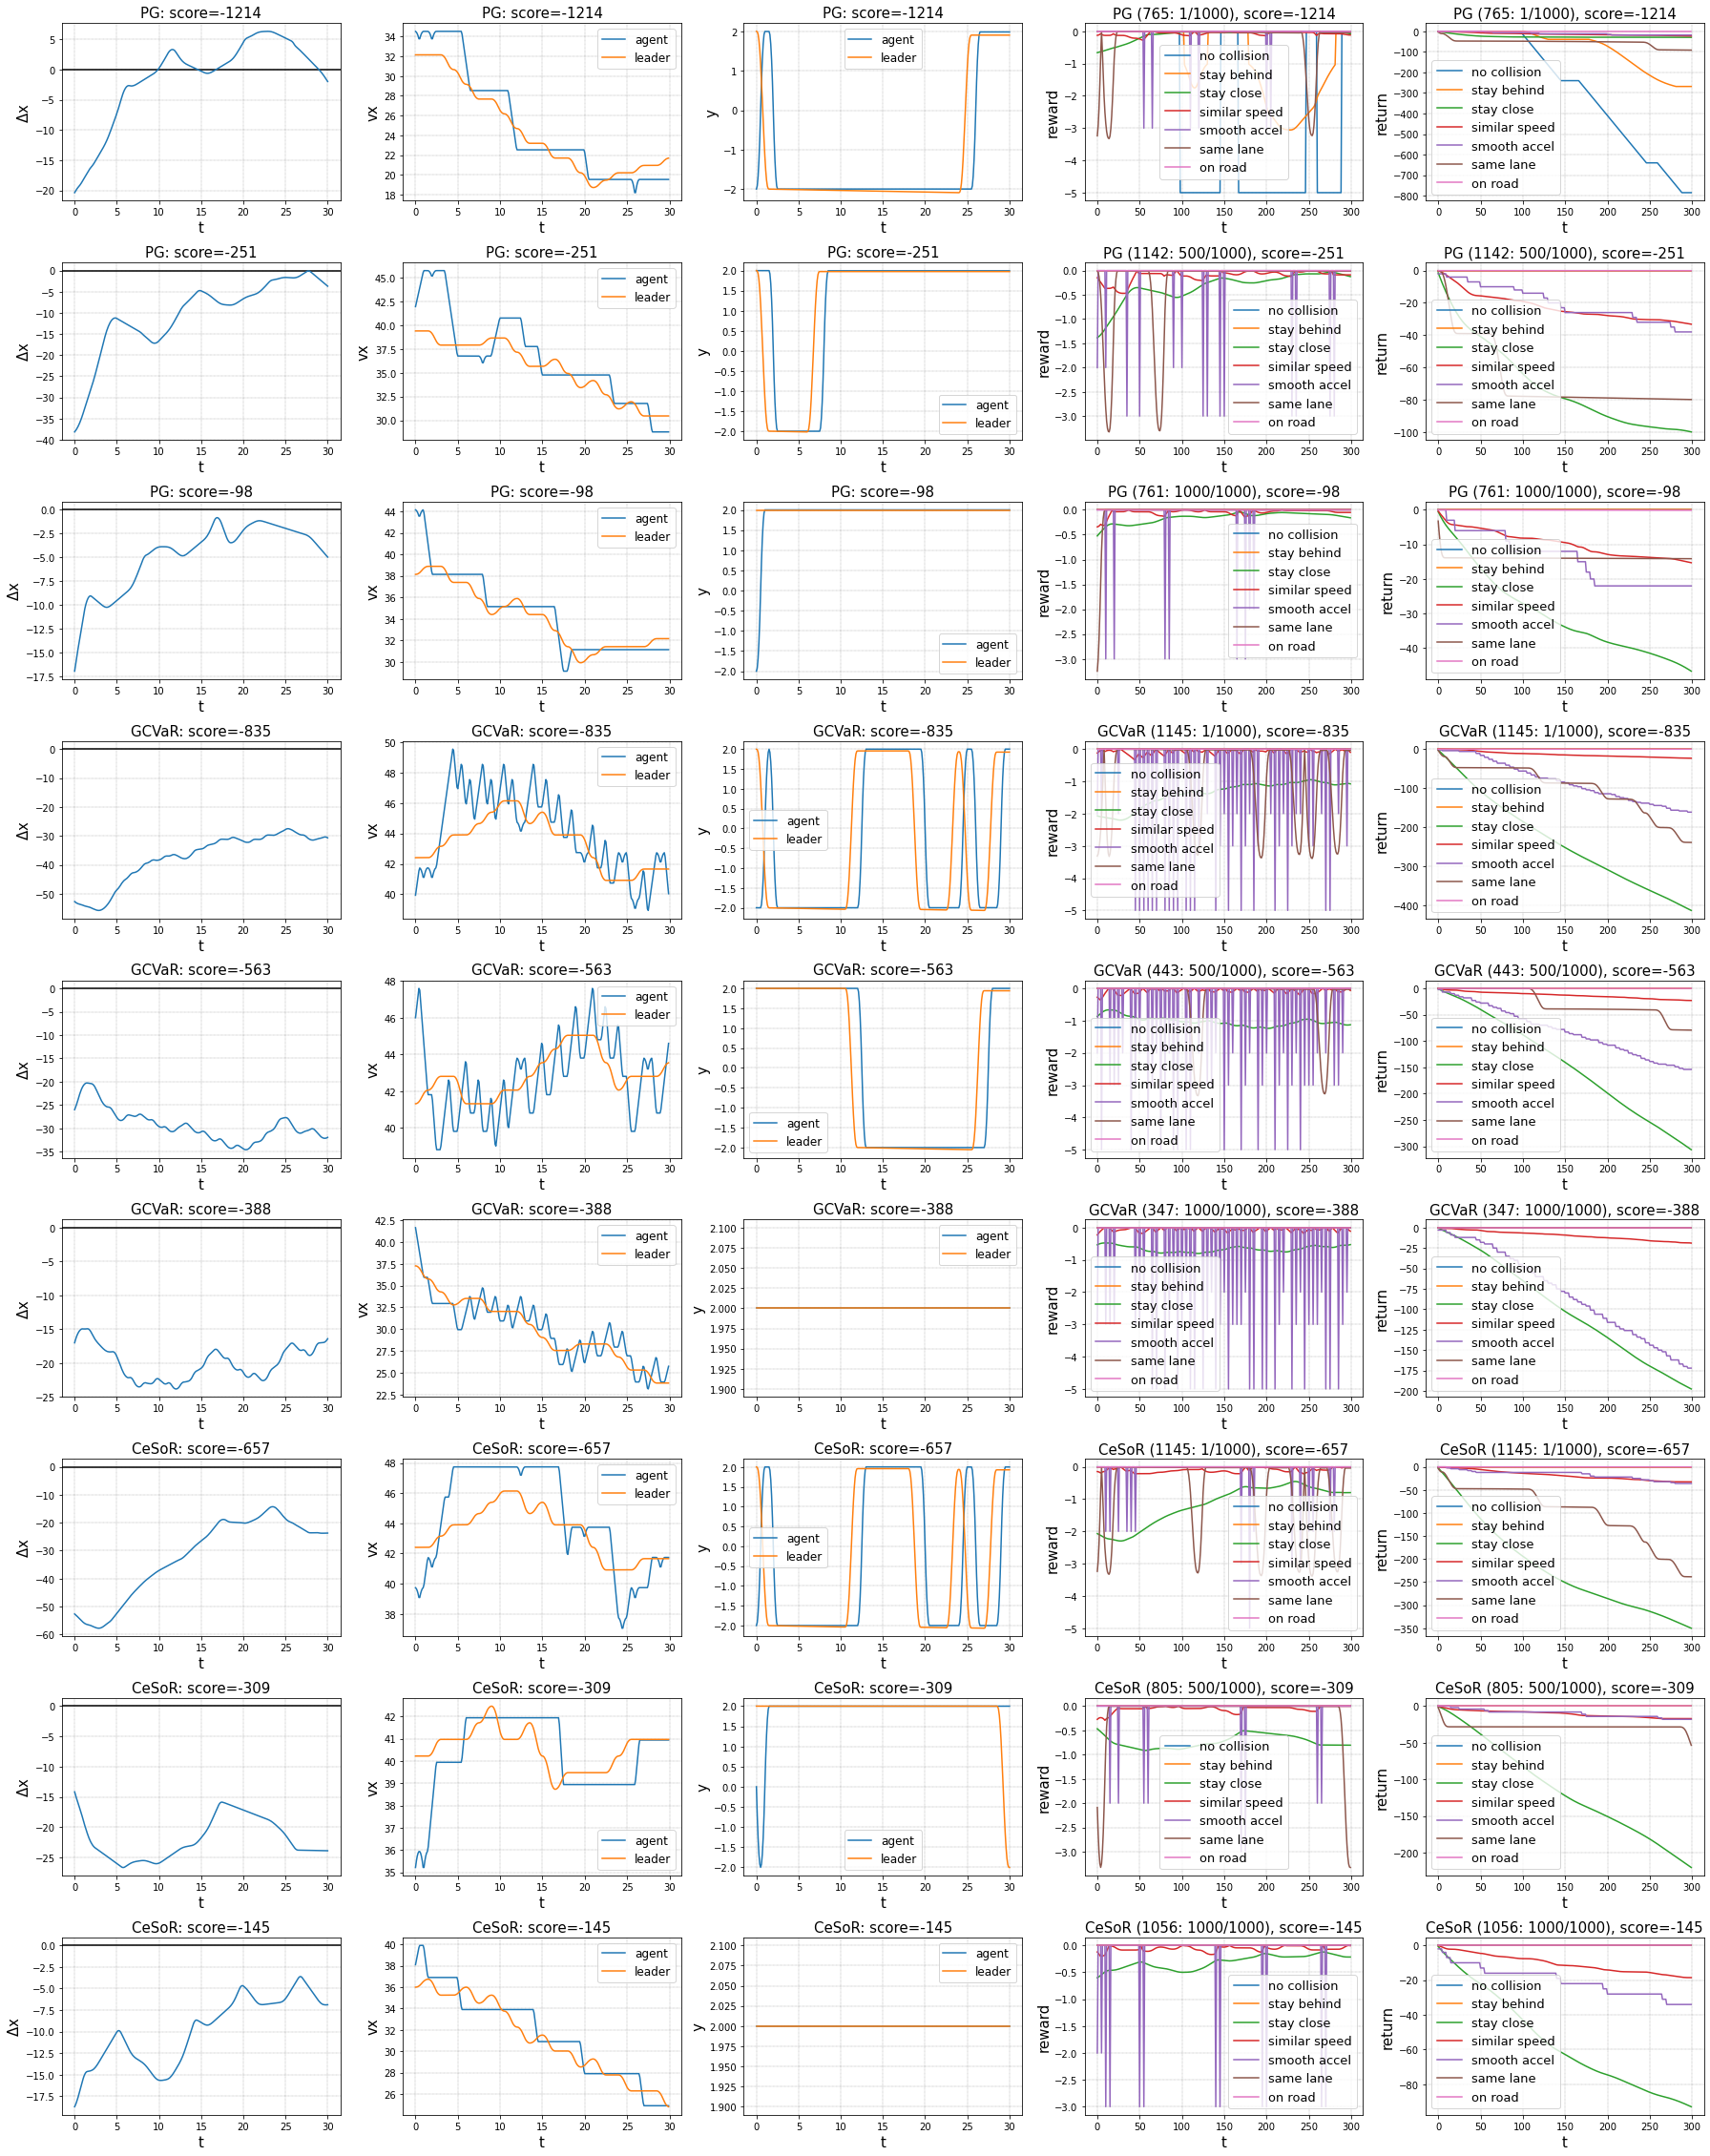

In [8]:
%%time
E.show_tests()
plt.savefig(f'outputs/{title}_examples.png', bbox_inches='tight');

Bad test episodes:

In [9]:
d = E.dd
d[(d.group=='test')&(d.score<-700)]

,agent,group,episode,ag_updates,ag_hash,ag_temperature,p_0,p_acc,p_dec,p_hard,...,th0,brakes,oil,L,log_prob,ret_loss,score,opt_selected,ce_selected,weight
600347,PG,test,347,500,-0x316e790edaf3e293,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-8.778033,-146.321136,-898.133071,NaN,NaN,NaN
600765,PG,test,765,500,-0x316e790edaf3e293,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-5.191854,-125.653481,-1214.473103,NaN,NaN,NaN
600801,PG,test,801,500,-0x316e790edaf3e293,0,0.35,0.3,0.248,0.002,...,0.195738,1.0,NaN,30,-7.645064,-131.145630,-992.290154,NaN,NaN,NaN
600821,PG,test,821,500,-0x316e790edaf3e293,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-7.974699,-95.708107,-755.780086,NaN,NaN,NaN
601435,GCVaR,test,235,500,-0x750e8e01460d7a69,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-19.266087,-204.450623,-705.498844,NaN,NaN,NaN
601519,GCVaR,test,319,500,-0x750e8e01460d7a69,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-20.069786,-232.533966,-800.414115,NaN,NaN,NaN
601689,GCVaR,test,489,500,-0x750e8e01460d7a69,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-17.743486,-200.724838,-722.441794,NaN,NaN,NaN
601720,GCVaR,test,520,500,-0x750e8e01460d7a69,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-12.228050,-135.786041,-729.714635,NaN,NaN,NaN
601727,GCVaR,test,527,500,-0x750e8e01460d7a69,0,0.35,0.3,0.248,0.002,...,0.000000,0.0,NaN,30,-21.451048,-238.230362,-703.488696,NaN,NaN,NaN
601743,GCVaR,test,543,500,-0x750e8e01460d7a69,0,0.35,0.3,0.248,0.002,...,-0.209604,0.0,NaN,30,-19.530138,-231.516739,-774.982221,NaN,NaN,NaN


In [10]:
episode = 347
frame = 161

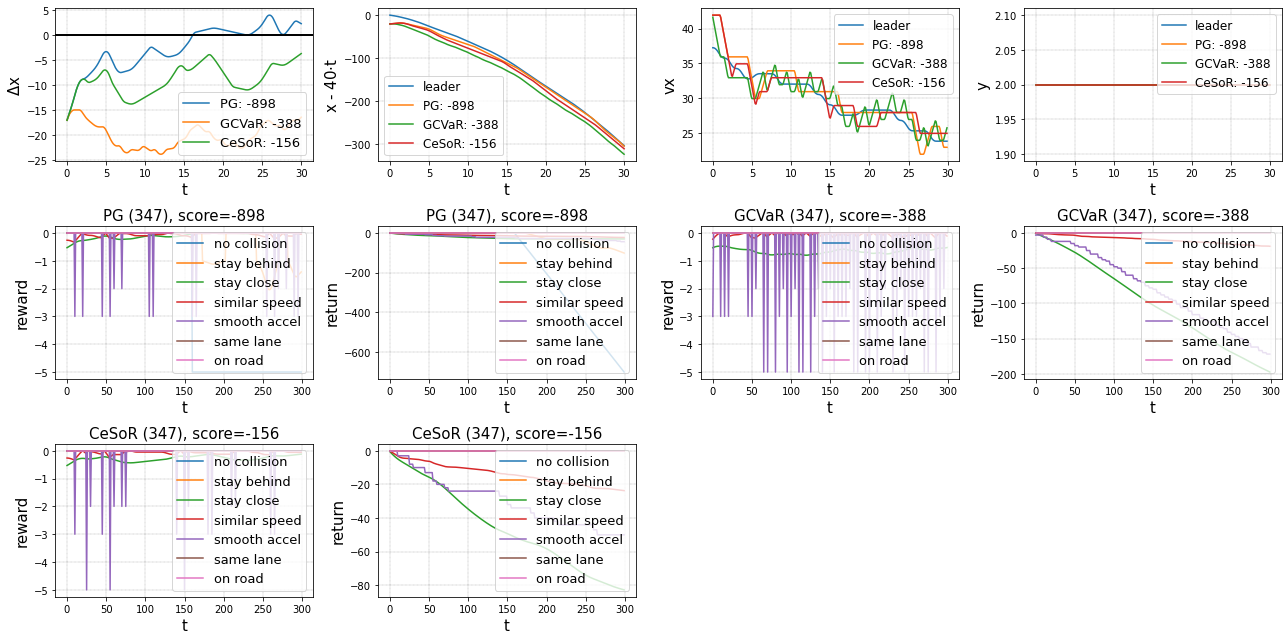

In [11]:
axs = E.analyze_episode(episode)
axs[0].legend(fontsize=13, loc='lower right')
plt.savefig(f'outputs/{title}_ep{episode:d}.png', bbox_inches='tight')

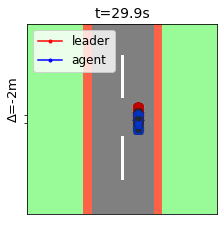

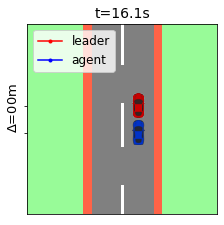

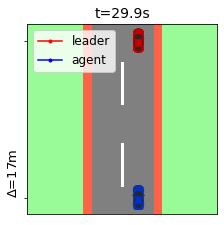

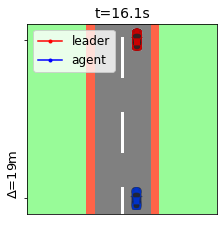

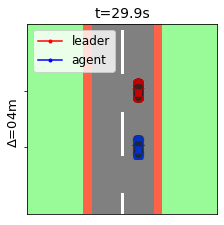

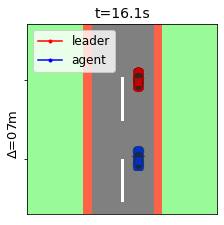

In [12]:
for agent in E.agents_names:
    E.run_episode((agent, 'test', episode), agent, gif=True)
    E.env.show_frame(frame)
    plt.savefig(f'outputs/{title}_{agent}_ep{episode:d}_frm{frame:d}.png', bbox_inches='tight')